In [1]:
import sys, os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy
import pickle

# for entropy
import zlib
import re
import math
from io import StringIO
from sklearn.linear_model import LinearRegression

import pylab 
import scipy.stats as stats
from scipy.stats import entropy
from scipy.stats import bernoulli
from math import log, e
import timeit
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA

plt.rcParams.update({'font.size': 14})

# LZW Compression

In [25]:
def compress(uncompressed):
    """Compress a string to a list of output symbols."""
 
    # Build the dictionary.
    dict_size = 256
    dictionary = {chr(i): i for i in range(dict_size)}
    
    w = ""
    result = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
 
    # Output the code for w.
    if w:
        result.append(dictionary[w])
    return result

def decompress(compressed):
    """Decompress a list of output ks to a string."""
 
    dict_size = 256
    dictionary = dict((i, chr(i)) for i in range(dict_size))
 
    # use StringIO, otherwise this becomes O(N^2)
    # due to string concatenation in a loop
    result = StringIO()
    w = chr(compressed.pop(0))
    result.write(w)
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result.write(entry)
 
        # Add w+entry[0] to the dictionary.
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
 
        w = entry
    return result.getvalue()

def entropy(p):
    return -p*log(p, 2) - (1-p)*log(1-p,2)

def list_to_string(a):
    return re.sub('\W+','', str(a) )

def lzw_test(delta):
    delta_string = list_to_string(delta)
    delta_compressed = compress(delta_string)
    delta_decompressed = decompress(delta_compressed)
    ratio = len(delta_compressed)/len(delta_string)
    error = np.sum(np.array([int(i) for i in delta_string]) != np.array([int(i) for i in delta_decompressed]))
    
    print("- using lzw")
    print("original size   : ", len(delta))
    print("compressed size : ", len(delta_compressed))
    print("ratio           : ", ratio)
    print("error           : ", error/len(delta_string))

def random_generator(size, p=0.5, space=50):
    numrand = np.random.binomial(1,p, size=size*space)
    spaced = numrand[0::space]
    a = list(spaced.astype(int))
    random_str = list_to_string(a)
    return random_str

def get_delta(x):
    delta = np.zeros(len(x)-1)
    delta[(x - x.shift(+1))[1:]>0] = 1
    # 1 = increase
    # 0 = not increase (decrease or stays the same)
    delta = delta.astype(int)
    return list(delta)


# Test 1. sys.getsizeof(X) vs. len(X)

In [3]:
ratio_list_sys =[]
ratio_list_len =[]

for size in np.logspace(3,27,9, base=2, dtype=int):
    print("size: ", size)
    uncompressed = random_generator(size)
    compressed = compress(uncompressed)
    
    # sys.getsizeof()
    compression_ratio = sys.getsizeof(compressed)/sys.getsizeof(uncompressed)
    ratio_list_sys.append(compression_ratio)
    print("measured using sys.getsizeof(): ", compression_ratio)
    
    # len()
    compression_ratio = len(compressed)/len(uncompressed)
    ratio_list_len.append(compression_ratio)
    print("measured using len():           ", compression_ratio)
    print()

size:  8
measured using sys.getsizeof():  2.245614035087719
measured using len():            0.625

size:  64
measured using sys.getsizeof():  2.336283185840708
measured using len():            0.390625

size:  512
measured using sys.getsizeof():  1.910873440285205
measured using len():            0.228515625

size:  4096
measured using sys.getsizeof():  1.325934861278649
measured using len():            0.151123046875

size:  32768
measured using sys.getsizeof():  0.9178169850991864
measured using len():            0.109893798828125

size:  262144
measured using sys.getsizeof():  0.7640173460008467
measured using len():            0.08521652221679688

size:  2097152
measured using sys.getsizeof():  0.5598166317868435
measured using len():            0.06928825378417969

size:  16777216
measured using sys.getsizeof():  0.5184077380908032
measured using len():            0.05820530652999878

size:  134217728
measured using sys.getsizeof():  0.4266174666266451
measured using len():      

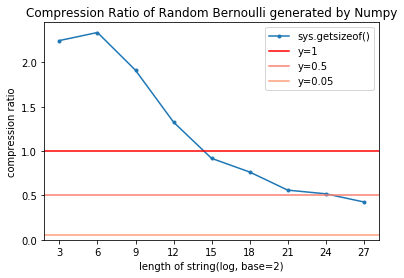

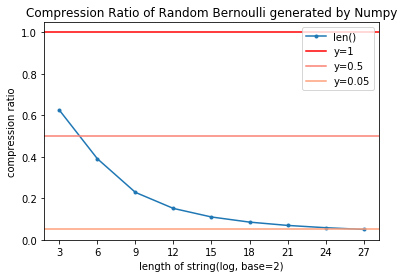

In [4]:
##### sys.getsizeof() plot
plt.plot(ratio_list_sys, marker='.', label="sys.getsizeof()")

plt.axhline(1, c="red", label="y=1")
plt.axhline(0.5, c="salmon", label="y=0.5")
plt.axhline(0.05, c="lightsalmon", label="y=0.05")

plt.xticks(np.arange(9),np.linspace(3,27,9, dtype=int))
plt.legend()
plt.xlabel("length of string(log, base=2)")
plt.ylabel("compression ratio")
plt.ylim(0,)
plt.title("Compression Ratio of Random Bernoulli generated by Numpy")
plt.show()

##### len() plot
plt.plot(ratio_list_len, marker='.', label="len()")

plt.axhline(1, c="red", label="y=1")
plt.axhline(0.5, c="salmon", label="y=0.5")
plt.axhline(0.05, c="lightsalmon", label="y=0.05")

plt.xticks(np.arange(9),np.linspace(3,27,9, dtype=int))
plt.legend()
plt.xlabel("length of string(log, base=2)")
plt.ylabel("compression ratio")
plt.ylim(0,)
plt.title("Compression Ratio of Random Bernoulli generated by Numpy")
plt.show()

# Test 2. regression model for a fixed input string size N

In [220]:
def regression_model(size, number_of_p=30, verbose=False):
    ratio_list =[]
    true_entropy = []
    for p in np.linspace(1e-5,0.5,number_of_p):
        true_entropy.append(entropy(p))
        uncompressed = random_generator(size, p)
        compressed = compress(uncompressed)
        compression_ratio = len(compressed)/len(uncompressed)
        ratio_list.append(compression_ratio)
        
        if verbose:
            print("p : ", p)
            print("theoretical entropy: ", entropy(p))
            print("compression ratio: ", compression_ratio)
            print()

    # linear regression
    reg = LinearRegression().fit(np.array(true_entropy[:]).reshape(-1, 1), np.array(ratio_list[:]))
    print("y = ax + b model")
    print("a = ", reg.coef_)
    print("b = ", reg.intercept_)

    plt.plot(true_entropy, ratio_list, marker='.', label = "LZW compressor")
    plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression")

    plt.title("Compression Ratio of size {} Bernoulli(p), 0<p<0.5".format(size))
    plt.xlabel("theoretical entropy")
    plt.ylabel("compression ratio")
    plt.legend()
    plt.show()

    return ratio_list, true_entropy

def get_entropy(size, compression_ratio):
    # mapping compression ratio to entropy
    ratio_list, true_entropy = regression_model(size, number_of_p=30, verbose=False)
    reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))
    return reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))

def f(p):
    return -p*log(p,2) - (1-p)*log(1-p,2)

def df(p):
    return -log(p/(1-p),2) 

def inverse_binary_entropy(H, a=0.001):
    # from entropy value, get p s.t. 0 < p < 0.5
    # a = accuracy
    p_hat = 0.25
    err = np.abs(f(p_hat) - H)
    while(err > a):
        err = np.abs(f(p_hat) - H)
        p_hat = p_hat - 0.01* (f(p_hat) - H) * df(p_hat)
        if (p_hat<0):
            p_hat = e-15
        if (p_hat>0.5):
            p_hat = 0.5
    
    return p_hat

y = ax + b model
a =  [0.13636728]
b =  0.03708274318499198


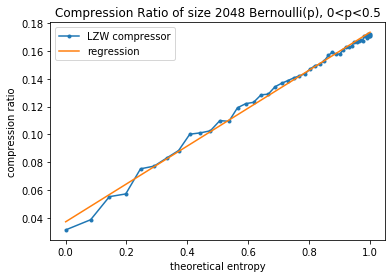

In [125]:
power = 11
size = 2 ** power

ratio_list, true_entropy = regression_model(size, number_of_p=50, verbose=False)
reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))

regression model for a fixed input string size N, multinomial case

In [113]:
def multinomial(n,p = [1/3,1/3,1/3]):
    final = []
    for i in range(n):
        result = np.random.multinomial(1, p)
        final.append(np.array(range(len(p)))[result == 1][0])
    return np.array(final).T


# Test 3. Assessing the difficulty of NBA prediction problem
## Theoretical Lower Bound

In [217]:
def get_entropy(size, compression_ratio):
    # mapping compression ratio to entropy
    ratio_list, true_entropy = regression_model(size, number_of_p=30, verbose=False)
    reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))
    return reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))

def f(p):
    return -p*log(p,2) - (1-p)*log(1-p,2)

def df(p):
    return -log(p/(1-p),2) 

def inverse_binary_entropy(H, a=0.001):
    # from entropy value, get p s.t. 0 < p < 0.5
    # a = accuracy
    p_hat = 0.25
    err = np.abs(f(p_hat) - H)
    while(err > a):
        err = np.abs(f(p_hat) - H)
        p_hat = p_hat - 0.01* (f(p_hat) - H) * df(p_hat)
        if (p_hat<0):
            p_hat = 0
        if (p_hat>0.5):
            p_hat = 0.5    
    return p_hat